# CMPT 459 Project - MLB Batting Analysis
By Ichiro Wang and Ajax Mok

GitHub repo [here](https://github.com/ichiro-wang/mlb-batting-analysis)

Dataset from Kaggle [here](https://www.kaggle.com/datasets/beckettnewton/mlb-hitting-pitching-data-2015-2024)

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

## Loading Data

In [157]:
data_path = "./data/batting_2015_2024.csv"
data = pd.read_csv(data_path)
print(f"Loaded file: {data_path}")
total_samples, total_features = data.shape[0], data.shape[1]
print(f"Dimensions: {total_samples} samples, {total_features} features")

Loaded file: ./data/batting_2015_2024.csv
Dimensions: 14051 samples, 321 features


Before we get started, we will fix columns we know are problematic.

For some reason there is an extra "season" column that contains the same values as the "Season" column, so we will remove one of them.

The "Age Rng" column that contains "Age" values in a weird format. We will remove "Age Rng".

There is a "Dol" column that contains dollar values with dollar signs, which makes pandas believe it is categorical. We will fix this.

You can do a quick eye-test in the data file to verify these columns for yourself.

In [158]:
# dealing with duplicate season columns
is_dup = data["Season"].equals(data["season"])
print(f"\nCheck if 'Season' and 'season' columns are duplicates: {is_dup}")
if is_dup:
    data = data.drop(columns=["season"])

# dealing with duplicate age/age-rng columns
data["Age Rng"] = data["Age Rng"].astype(str).str.extract(r"(\d+)").astype(int)
is_dup = data["Age"].equals(data["Age Rng"])
print(f"\nCheck if 'Age' and 'Age Rng' are duplicates: {is_dup}")
if is_dup:
    data = data.drop(columns=["Age Rng"])

# dealing with dollar formatting
# parentheses represent negative dollar values
data["Dol"] = (
    data["Dol"]
    .str.replace("$", "", regex=False)
    .str.replace("(", "-", regex=False)
    .str.replace(")", "", regex=False)
    .astype(float)
)


Check if 'Season' and 'season' columns are duplicates: True

Check if 'Age' and 'Age Rng' are duplicates: True


## Data Overview

In [159]:
print("First 5 Rows")
print(data.head(5))

print("\nFeature types:")

print("\nCategorical features:")
categorical_features = data.select_dtypes(include=["object"]).columns
for feat in categorical_features:
    print(f"{feat}: {data[feat].nunique()} unique values")

print("\nNumerical features: Everything else")
numerical_features = [feat for feat in data.columns if feat not in categorical_features]

print(f"Seasons: {data["Season"].unique().min()} - {data["Season"].unique().max()}")
print(f"Ages: {data["Age"].unique().min()} - {data["Age"].unique().max()}")
print("etc.")
print(data.describe())

First 5 Rows
    IDfg  Season              Name Team  Age    G   AB   PA    H   1B  ...  \
0  11579    2015      Bryce Harper  WSN   22  153  521  654  172   91  ...   
1  10155    2015        Mike Trout  LAA   23  159  575  682  172   93  ...   
2   5038    2015    Josh Donaldson  TOR   29  158  620  711  184  100  ...   
3   4314    2015        Joey Votto  CIN   31  158  545  695  171  107  ...   
4   9218    2015  Paul Goldschmidt  ARI   27  159  567  695  182  109  ...   

   maxEV  HardHit  HardHit%  Events  CStr%   CSW%    xBA   xSLG  xwOBA  L-WAR  
0  116.0    188.0     0.477     394  0.118  0.226  0.292  0.544  0.418    9.3  
1  117.7    205.0     0.486     422  0.207  0.282  0.297  0.588  0.422    9.3  
2  113.6    232.0     0.465     499  0.145  0.255  0.279  0.545  0.390    8.7  
3  109.3    175.0     0.425     412  0.177  0.254  0.289  0.541  0.422    7.3  
4  114.0    197.0     0.465     424  0.181  0.266  0.279  0.558  0.403    7.2  

[5 rows x 319 columns]

Feature types

## Plate Appearance (PA) distribution
MLB defines a PA as a batter's turn at the plate. Or simply, each turn to hit.

Some players, such as pitchers, don't get many opportunities to hit, or have much less opportunities to hit than regular players.

We want to see how many of these players there are to remove them from our dataset

We want to remove players such as pitchers because predicting a pitchers hitting ability is not particularly useful given their role in the game and their limited PA sample sizes.

In [160]:
print("Plate Appearance distribution")
print(data["PA"].describe())

pa_thresholds = [50, 100, 150, 200, 250, 300, 400, 500]
print("\nPA's by threshold. These represent how many players had more PA's than these thresholds.")
for threshold in pa_thresholds:
    split = data[data["PA"] >= threshold]
    print(f"PA >= {threshold}: {len(split)} samples")

Plate Appearance distribution
count    14051.000000
mean       122.559391
std        194.537007
min          0.000000
25%          0.000000
50%          6.000000
75%        182.000000
max        753.000000
Name: PA, dtype: float64

PA's by threshold. These represent how many players had more PA's than these thresholds.
PA >= 50: 5336 samples
PA >= 100: 4375 samples
PA >= 150: 3822 samples
PA >= 200: 3340 samples
PA >= 250: 2865 samples
PA >= 300: 2492 samples
PA >= 400: 1863 samples
PA >= 500: 1248 samples


## Setting a PA Threshold

According to the MLB Rate Stats Qualifiers ([link](https://www.mlb.com/glossary/standard-stats/rate-stats-qualifiers)), a batter must record at least 3.1 PA's per scheduled league game to qualify for certain invididual stat category leadership. 

Over a full season (162 games), this adds up to 502 PA's. 

Setting the threshold high, such as 500, shrinks our dataset to just 1248 samples. 

Setting it too low, such as 100, provides many more samples, but less PA's means stats could be more influenced by luck or randomness.

$\sigma_{300} / \sigma_{100} = \sqrt{100/300}= 0.577$

$\sigma^{2}_{300} / \sigma^{2}_{100} = 0.333$

$\sigma_{500} / \sigma_{300} = \sqrt{300/500}= 0.775$

$\sigma^{2}_{500} / \sigma^{2}_{300} = 0.600$

Going from 100 -> 300 PA's reduces $\sigma$ by roughly $42$%

Going from 300 -> 500 PA's reduces $\sigma$ by roughly $22$%

A threshold of 300 gives us a decent dataset size while reducing the influence of luck on player stats. 

## Filtering by PA Threshold

In [161]:
PA_THRESHOLD = 250
data = data[data["PA"] >= PA_THRESHOLD]

print(f"\nRemaining samples after filtering by PA: {len(data)}")
print(f"Samples removed: {total_samples - len(data)}")


Remaining samples after filtering by PA: 2865
Samples removed: 11186


## Missing Values

We handle missing values by removing or imputing.

In [162]:
print("\nMissing Values:")
missing = data.isna().sum()
missing_pct = (missing / len(data)) * 100

missing_df = pd.DataFrame({"Missing Count": missing, "Percentage": missing_pct})

missing_info = missing_df[missing_df["Missing Count"] > 0].sort_values(
    "Missing Count", ascending=False
)
print(missing_info)

# columns missing over 50% of values will be removed
missing_threshold = 50
to_drop = missing_df[missing_df["Percentage"] > missing_threshold].index.tolist()
print(f"\nDropping columns with over {missing_threshold}% of values missing:")
print(to_drop)
data = data.drop(columns=to_drop)

# columns missing less than 50% of values will be imputed with median
numerical_features = data.select_dtypes(include=[np.number]).columns
data[numerical_features] = data[numerical_features].fillna(
    data[numerical_features].median()
)

# imputing categorical
# a player missing a team means they were on multiple teams
data["Team"] = data["Team"].replace("- - -", "Multiple")
data["Name"] = data["Name"].fillna("Unknown")

total_missing = data.isna().sum().sum()
print(f"\nTotal missing values remaining: {total_missing}")


Missing Values:
           Missing Count  Percentage
PO%                 2865  100.000000
FT% (sc)            2865  100.000000
wFT (sc)            2865  100.000000
FT-Z (sc)           2865  100.000000
FT-X (sc)           2865  100.000000
...                  ...         ...
FS-X (sc)              1    0.034904
vFS (sc)               1    0.034904
xBA                    1    0.034904
xSLG                   1    0.034904
xwOBA                  1    0.034904

[79 rows x 2 columns]

Dropping columns with over 50% of values missing:
['KN%', 'KNv', 'PO%', 'wKN', 'wKN/C', 'FT% (sc)', 'FO% (sc)', 'EP% (sc)', 'SC% (sc)', 'KN% (sc)', 'UN% (sc)', 'vFT (sc)', 'vFO (sc)', 'vEP (sc)', 'vSC (sc)', 'vKN (sc)', 'FT-X (sc)', 'FO-X (sc)', 'EP-X (sc)', 'SC-X (sc)', 'KN-X (sc)', 'FT-Z (sc)', 'FO-Z (sc)', 'EP-Z (sc)', 'SC-Z (sc)', 'KN-Z (sc)', 'wFT (sc)', 'wFO (sc)', 'wEP (sc)', 'wSC (sc)', 'wKN (sc)', 'wFT/C (sc)', 'wFO/C (sc)', 'wEP/C (sc)', 'wSC/C (sc)', 'wKN/C (sc)', 'CS% (pi)', 'KN% (pi)', 'SB% (pi)',

## 

## Plotting Distributions

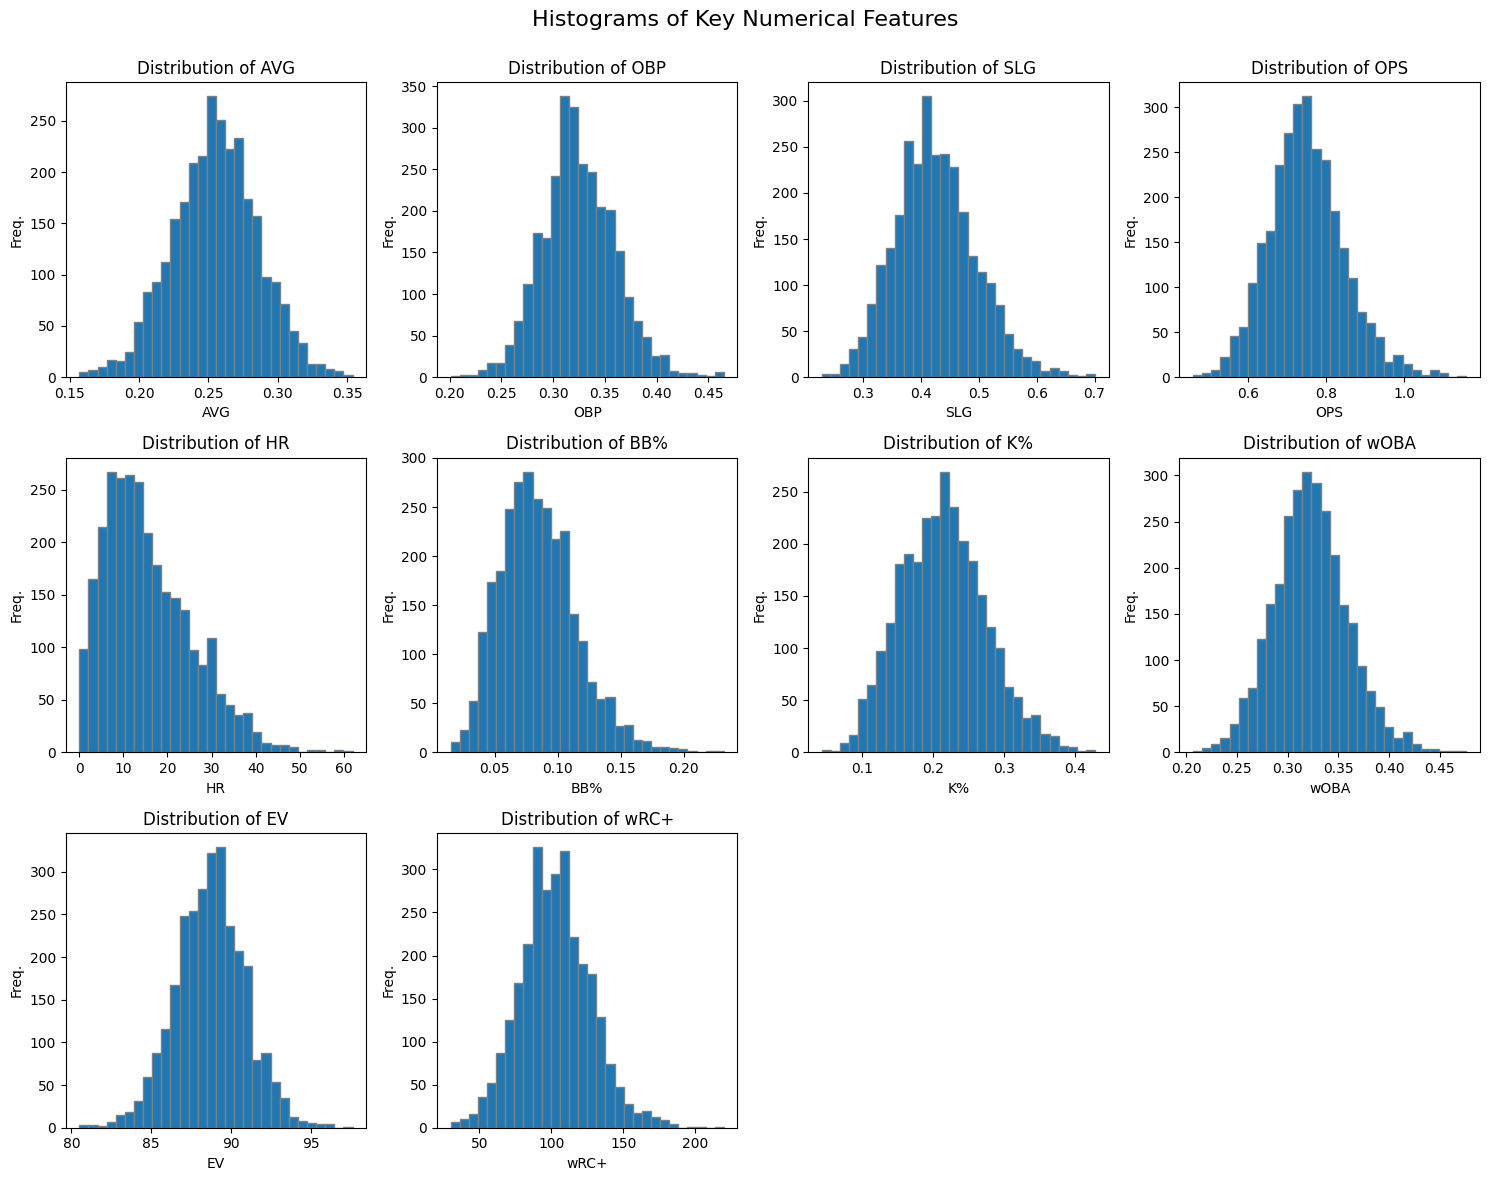

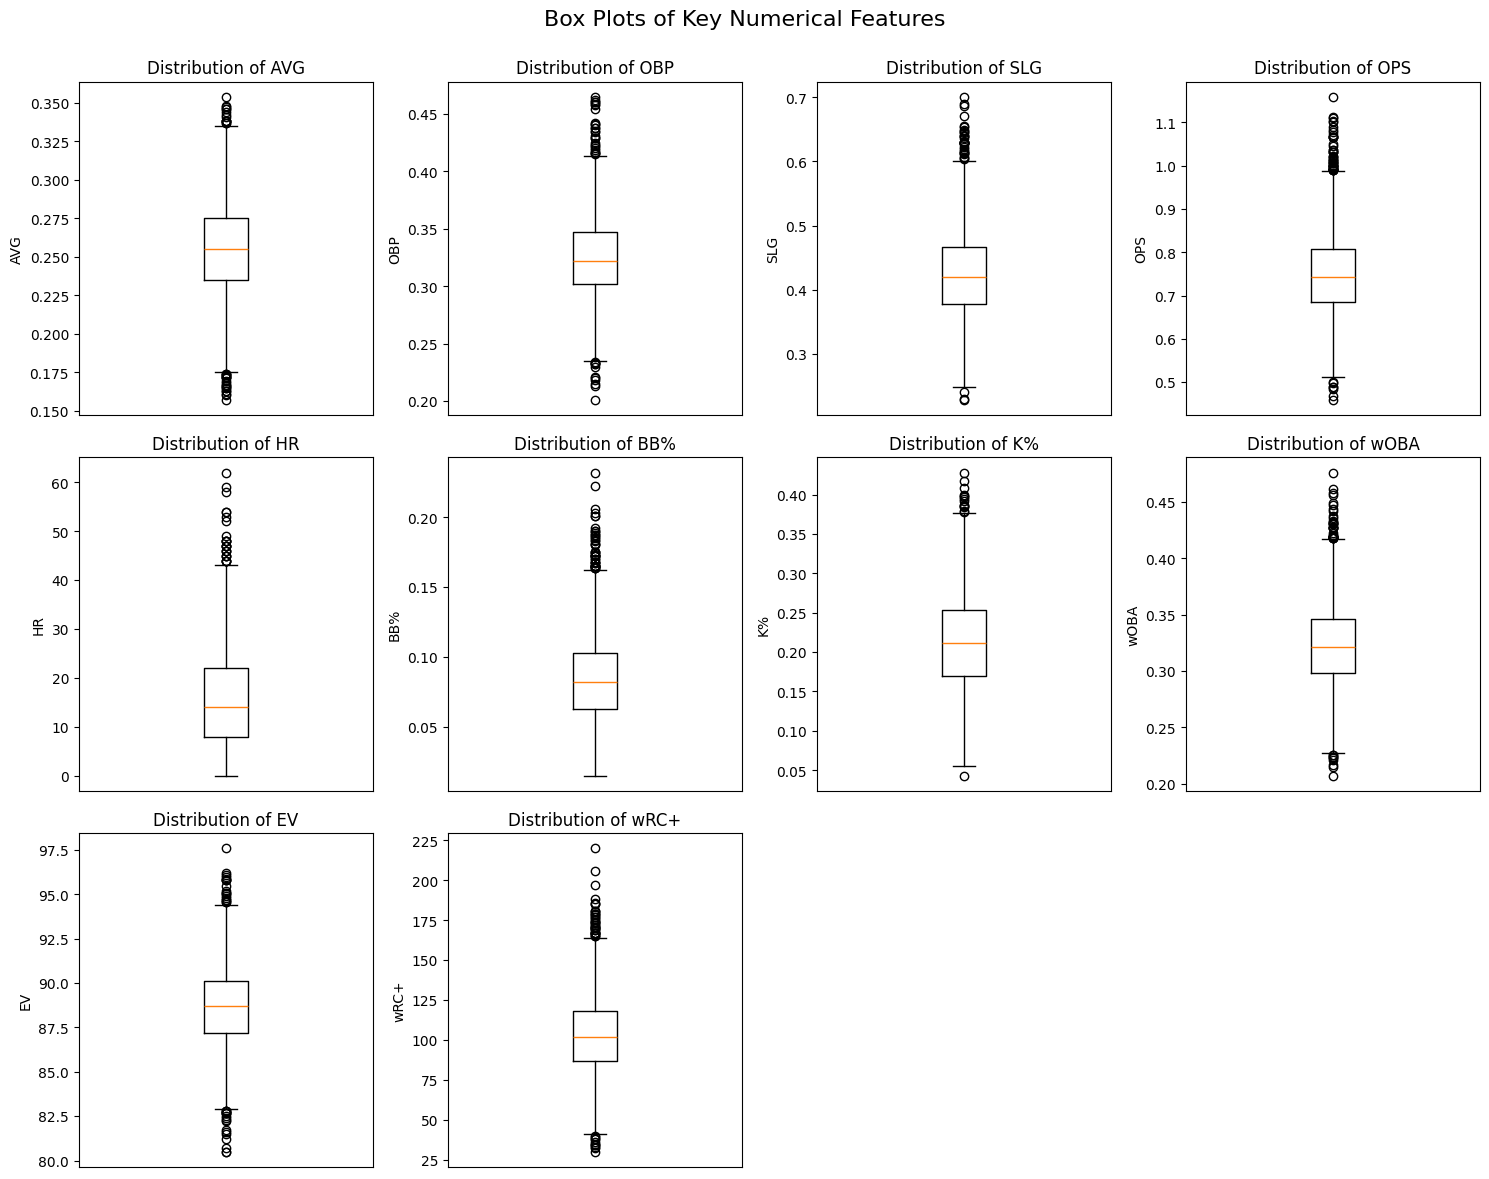

In [163]:
key_stats = ["AVG", "OBP", "SLG", "OPS", "HR", "BB%", "K%", "wOBA", "EV", "wRC+"]

# histograms
fig, axs = plt.subplots(3, 4, figsize=(15, 12))
axs = axs.ravel()  # flatten to 1D array

for i, stat in enumerate(key_stats):
    axs[i].hist(data[stat], bins=30, edgecolor="grey")
    axs[i].set_title(f"Distribution of {stat}")
    axs[i].set_xlabel(stat)
    axs[i].set_ylabel("Freq.")

# hide remaining axes
for ax in axs[len(key_stats) :]:
    ax.set_visible(False)

plt.suptitle("Histograms of Key Numerical Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# box plots
fig, axs = plt.subplots(3, 4, figsize=(15, 12))
axs = axs.ravel()  # flatten to 1D array

for i, stat in enumerate(key_stats):
    axs[i].boxplot(data[stat])
    axs[i].set_title(f"Distribution of {stat}")
    axs[i].set_xticks([])
    axs[i].set_ylabel(stat)

# hide remaining axes
for ax in axs[len(key_stats) :]:
    ax.set_visible(False)

plt.suptitle("Box Plots of Key Numerical Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## Visualizing Relationships


Correlation of features
Features SLG, OPS: 0.9612517396267367
Features SLG, wOBA: 0.9250589451437693
Features OPS, wOBA: 0.9908816218895865
Features OPS, wRC+: 0.9560513862594657
Features wOBA, wRC+: 0.9747665472922121


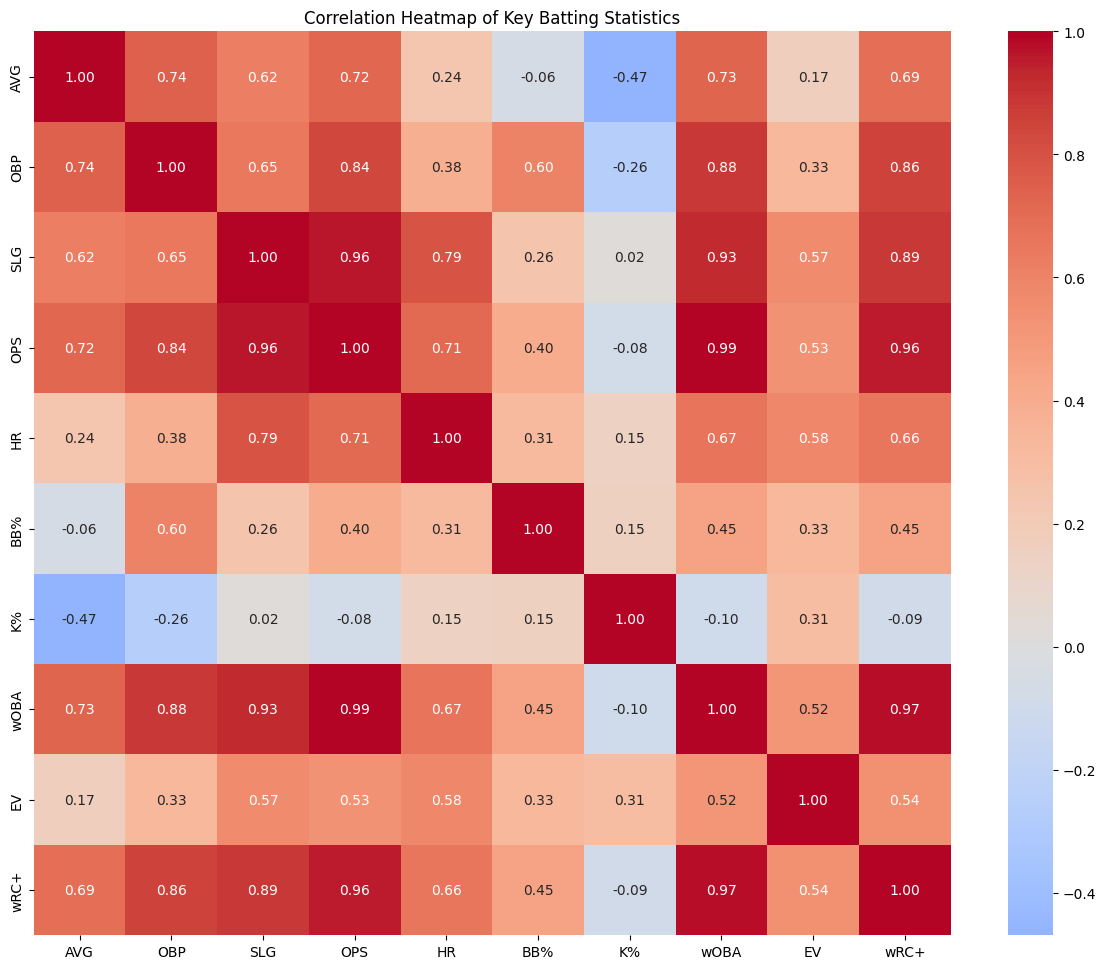

In [164]:
corr_matrix = data[key_stats].corr()

# check most correlated features
high_corr = []
low_corr = []
for row in range(len(corr_matrix)):
    for col in range(row + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[row, col] > 0.9:
            high_corr.append(
                [
                    corr_matrix.iloc[row, col],
                    corr_matrix.columns[row],
                    corr_matrix.columns[col],
                ]
            )
        elif corr_matrix.iloc[row, col] < -0.9:
            low_corr.append(
                [
                    corr_matrix.iloc[row, col],
                    corr_matrix.columns[row],
                    corr_matrix.columns[col],
                ]
            )

print("\nCorrelation of features")
for corr, feat1, feat2 in high_corr:
    print(f"Features {feat1}, {feat2}: {corr}")
for corr, feat1, feat2 in low_corr:
    print(f"Features {feat1}, {feat2}: {corr}")

# plotting heatmap with seaborn
plt.figure(figsize=(12, 10))
plt.title("Correlation Heatmap of Key Batting Statistics")
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", center=0)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## Data Plot:

Number of numeric columns detected: 256


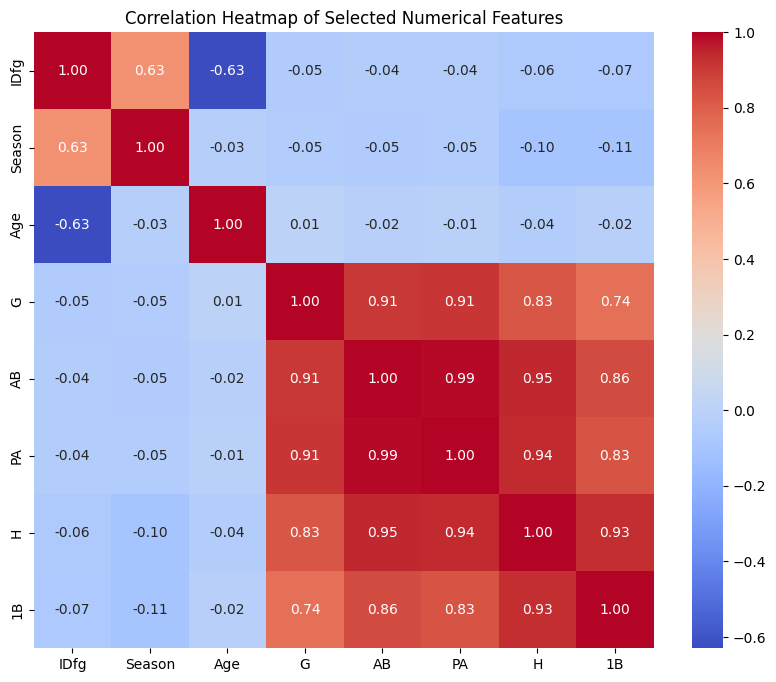

In [165]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
print("Number of numeric columns detected:", len(numeric_cols))

plot_cols = [
    c
    for c in [
        "games_played",
        "at_bats",
        "runs",
        "hits",
        "homeruns",
        "rbi",
        "strikeouts",
        "batting_average",
    ]
    if c in data.columns
]
if len(plot_cols) == 0:
    plot_cols = numeric_cols[:8]

# print('Plotting columns:', plot_cols)

# # Histograms
# plt.figure(figsize=(14,10))
# data[plot_cols].hist(bins=30, figsize=(14,10))
# plt.suptitle('Distributions of Key Numerical Features', fontsize=16)
# plt.show()

# # Boxplots
# plt.figure(figsize=(14,8))
# _ = data[plot_cols].plot(kind='box', subplots=True, layout=(2,4), figsize=(14,8), sharex=False, sharey=False)
# plt.suptitle('Boxplots of Key Numerical Features', fontsize=16)
# plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = data[plot_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Selected Numerical Features")
plt.show()

### Discussion 

# Preprocessing

In [166]:
# # Handle missing data
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    data[col] = data[col].fillna(data[col].median())
data = data.dropna(axis=1, how="all")
print("\nAfter Imputation, Missing Data Columns:", data.isnull().sum().sum())

# Normalize numerical features
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
cols_to_scale = [col for col in numeric_cols if col not in ["IDfg", "Season"]]
data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])

# Hot encode categorical features
one_Hot = ["Team", "Age Rng", "Dol"]
for col in one_Hot:
    if col in data.columns:
        data[col] = data[col].astype("category")
data = pd.get_dummies(data, columns=one_Hot, drop_first=True)
print("\nData shape after encoding:", data.shape)

# PCA for dimensionality reduction
id_cols = ["IDfg", "Season", "Name"]
features_pca = [col for col in data.columns if col not in id_cols]
X = data[features_pca]
X_id = data[id_cols]
X_id = X_id.reset_index(drop=True)
pca_transformer = PCA(n_components=0.95)
X_pca = pca_transformer.fit_transform(X)
pca_cols = [f"PC_{i+1}" for i in range(X_pca.shape[1])]
pca_df = pd.DataFrame(X_pca, columns=pca_cols)
reduced = pd.concat([X_id, pca_df], axis=1)
print("\nShape after Preprocessing and PCA:", reduced.shape)
print("Number of features after reduction (PCA Components):", pca_df.shape[1])


After Imputation, Missing Data Columns: 0


KeyError: "['Age Rng'] not in index"